# Code to detect once in a row the central row to folow

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, peak_prominences

class LineDetector:
    def __init__(self,
                 buffer_size=3,
                 peak_mode='highest',
                 min_peak_prominence=None,
                 min_peak_distance=50,
                 min_peak_height=None,
                 crop_ratio=0.3,    # crop the upper part of the image
                 weight_bottom=1.0):  # range to weight the sum when transfering to 1D
        # Store detection parameters
        self.projection_buffer = []
        self.buffer_size = buffer_size
        self.peak_mode = peak_mode
        self.min_peak_prominence = min_peak_prominence
        self.min_peak_distance = min_peak_distance
        self.min_peak_height = min_peak_height
        self.crop_ratio = crop_ratio
        self.weight_bottom = weight_bottom  # maximum weight applied to bottom row

    def crop_image(self, image):
        """Crop the upper part of the image based on crop_ratio."""
        h = image.shape[0]
        crop_start = int(h * self.crop_ratio)
        return image[crop_start:, :]

    def generate_excessive_green_mask(self, image):
        """Generate a binary mask that highlights green areas."""
        cropped = self.crop_image(image)
        hsv = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)

        lower_green = np.array([36, 25, 25])
        upper_green = np.array([86, 255, 255])
        mask_green = cv2.inRange(hsv, lower_green, upper_green)

        _, binary_mask = cv2.threshold(mask_green, 0, 255,
                                       cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return binary_mask, cropped

    def smooth_projection(self, projection, sigma=2):
        return gaussian_filter1d(projection, sigma=sigma)

    def weighted_vertical_projection(self, mask):
        """Compute vertical projection with row weighting towards the bottom."""
        h, w = mask.shape
        # Linear weight from top (0.1) to bottom (weight_bottom)
        weights = np.linspace(self.weight_bottom, 1.0, h)
        return np.sum(mask * weights[:, None], axis=0)

    def find_peaks_on_accumulated(self, smoothed_projection):
        if self.projection_buffer and len(self.projection_buffer[0]) != len(smoothed_projection):
            self.projection_buffer = []

        self.projection_buffer.append(smoothed_projection)
        if len(self.projection_buffer) > self.buffer_size:
            self.projection_buffer.pop(0)

        accumulated = np.sum(self.projection_buffer, axis=0).astype(np.float64)
        peaks, properties = find_peaks(accumulated, distance=self.min_peak_distance)

        if len(peaks) > 0:
            properties.setdefault('peak_heights', accumulated[peaks])
            properties['prominences'] = peak_prominences(accumulated, peaks)[0]
        else:
            return int(np.argmax(accumulated)), accumulated, peaks, properties

        if self.peak_mode == 'highest':
            chosen = int(peaks[np.argmax(accumulated[peaks])])
        elif self.peak_mode == 'prominent':
            chosen = int(peaks[np.argmax(properties['prominences'])])
        else:
            center = len(accumulated) // 2
            chosen = int(min(peaks, key=lambda x: abs(x - center)))

        return chosen, accumulated, peaks, properties

    def detect_full(self, image, sigma=2):
        """Run the full pipeline: crop, mask, weighted projection, smooth, detect peak."""
        mask, cropped = self.generate_excessive_green_mask(image)
        vertical_projection = self.weighted_vertical_projection(mask)
        smoothed = self.smooth_projection(vertical_projection, sigma=sigma)
        chosen, accumulated, peaks, properties = self.find_peaks_on_accumulated(smoothed)

        return {
            'cropped': cropped,
            'mask': mask,
            'accumulated': accumulated,
            'peaks': peaks,
            'properties': properties,
            'chosen': chosen
        }

# ----------------------
# Plotting function
# ----------------------
def plot_pipeline(image_paths, detector, sigma=2):
    n = len(image_paths)
    fig, axs = plt.subplots(n, 5, figsize=(20, 4 * n))
    if n == 1:
        axs = np.expand_dims(axs, axis=0)

    for i, p in enumerate(image_paths):
        img = cv2.imread(p)
        if img is None:
            raise FileNotFoundError(f"Cannot load image: {p}")

        res = detector.detect_full(img, sigma=sigma)

        out = res['cropped'].copy()
        cv2.line(out, (res['chosen'], 0), (res['chosen'], out.shape[0]-1), (255,0,0), 2)
        cv2.line(out, (out.shape[1]//2,0), (out.shape[1]//2, out.shape[0]-1), (0,255,0), 2)

        axs[i,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i,0].set_title(f"Original ({p})"); axs[i,0].axis('off')

        axs[i,1].imshow(cv2.cvtColor(res['cropped'], cv2.COLOR_BGR2RGB))
        axs[i,1].set_title("Cropped (bottom portion)"); axs[i,1].axis('off')

        axs[i,2].imshow(res['mask'], cmap='gray')
        axs[i,2].set_title("Excessive Green Mask"); axs[i,2].axis('off')

        axs[i,3].plot(res['accumulated'], label='projection')
        if len(res['peaks'])>0:
            axs[i,3].scatter(res['peaks'], res['accumulated'][res['peaks']], marker='x', label='peaks')
        axs[i,3].axvline(res['chosen'], color='red', linestyle='--', label='chosen')
        axs[i,3].axvline(len(res['accumulated'])//2, color='green', linestyle='--', label='center')
        axs[i,3].set_title("Vertical Projection"); axs[i,3].legend()

        axs[i,4].imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
        axs[i,4].set_title("Detected Line"); axs[i,4].axis('off')

    plt.tight_layout(); plt.show()


## Working example
Use the distance between the center and the found peak to adjust the direction of the robot.

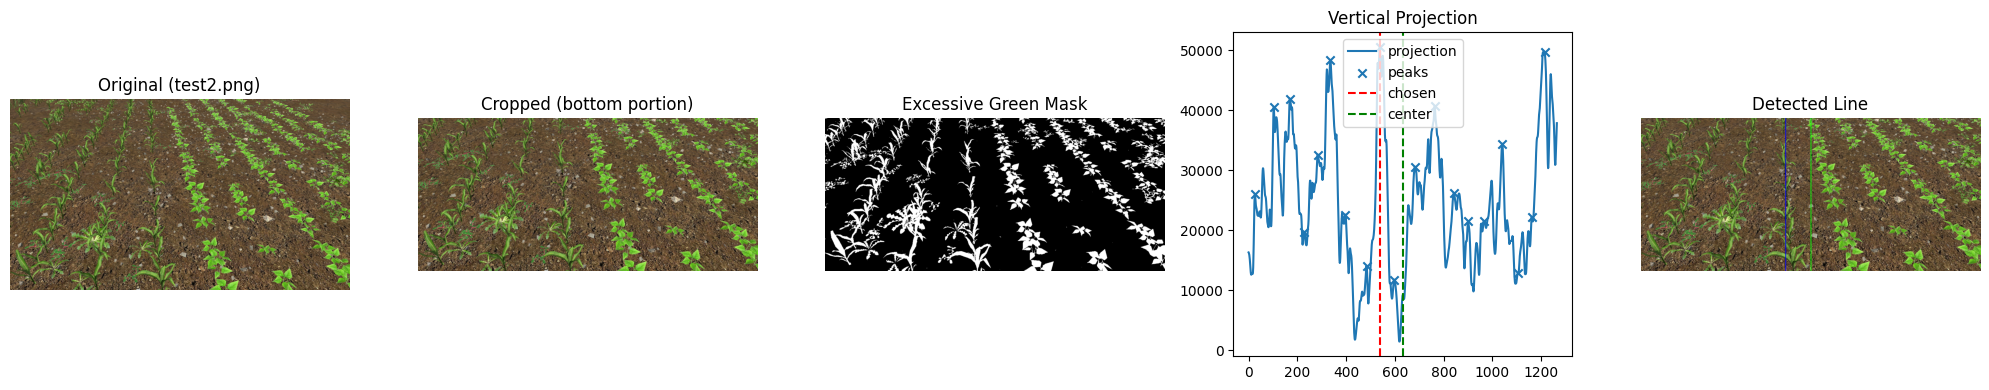

In [ ]:
# ---------------------------
# Run on image 1
# ---------------------------
if __name__ == "__main__":
    # Create the line detector with desired parameters
    detector = LineDetector(
        buffer_size=3,
        peak_mode='highest',   # choose the tallest peak
        crop_ratio=0.2,        # crop top 20% of the image
        weight_bottom=1.0      # increase influence of bottom rows
    )

    # List of images to process
    image_paths = ["test2.png"]

    # Run the full pipeline and plot results
    plot_pipeline(image_paths, detector, sigma=2)


## Unsucessul example: 
the crop is to heterogeneous and camera angle was to high

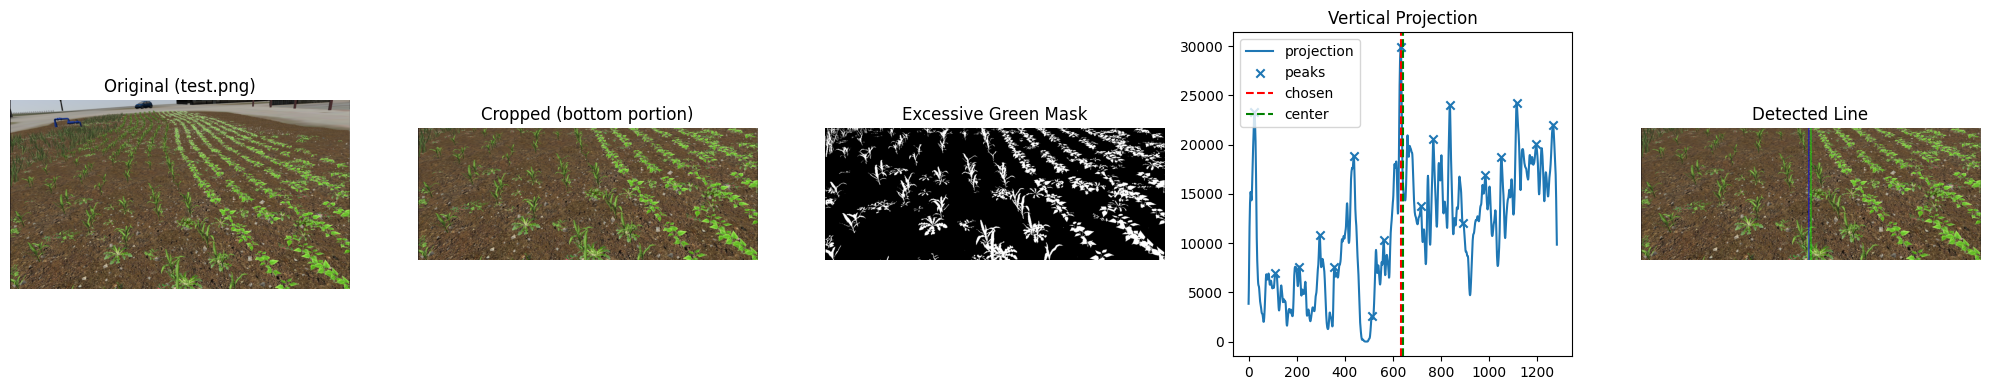

In [ ]:
# ---------------------------
# Run on images 2
# ---------------------------
if __name__ == "__main__":
    # Create the line detector with desired parameters
    detector = LineDetector(
        buffer_size=3,
        peak_mode='highest',   # choose the tallest peak
        crop_ratio=0.30,        # crop top 40% of the image
        weight_bottom=0.2      # increase influence of bottom rows
    )

    # List of images to process
    image_paths = [ "test.png"]

    # Run the full pipeline and plot results
    plot_pipeline(image_paths, detector, sigma=2)
